# RMS Graph

Want to produce a root mean squared against speed (length - which is size of frame moving across the image making it appear to be moving) graph to show how the error and subsquent quality of the image changes compared to the 'still' object as the speed increases. Going to do this for rolling ball, for the natural and frequency ordered Hadamard patterns.

- First going to produce the RMS value for one length and then make a loop.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import time
from PIL import Image, ImageOps
from scipy.linalg import hadamard

- First reconstruct the image using natural ordered Hadamard and length of 0
- Define a function for single pixel imaging

In [2]:
rc64 = "racecar64.jpg"
sz = 64
imsize = sz**2
I = np.identity(imsize)
H = hadamard(imsize)
def spi(imagefile,pattern,length):
    raw_img = cv2.imread(imagefile)
    gray_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
    gray_img = cv2.resize(gray_img,(sz*3,sz))
    objs = np.array(gray_img)
    m = np.zeros((imsize,1))
    image = np.zeros((sz,sz))
    
    for i in range(0,imsize):                                  # for each pixel value
        a = round(i*(length/imsize))                           # i*(50/32^2) - moving through diff sections
        obj = objs[:,a:a+sz]                                   # now obj changes for each measurement - simulates moving object
        samplingVector = pattern[i,:]                       # row index of pattern matrix and all columns - choosing each row from iden/hadamard matrix
        samplingPattern = np.reshape(samplingVector,(sz,sz))   # reshaping to image size, for each i the 1 moves along the rows of the matrices - reshapes each row of iden/hadamard matrix to sz x s
        m[i] = np.sum(samplingPattern * obj)                   # taking measurements, sum of patterns*image, there's a pattern for each zero in the zero array m - puts obj as a column vector basically
        image = samplingPattern * obj + image  
    
    recon = np.matmul(pattern,m)                    # recon is image formed by multiplying pattern used and signal#
    return np.reshape(recon, (sz,sz))

stillcar = spi(rc64,H,0)

 - Now define a function to determine rms. Variables of 0 length and 50 length images are recon_test and recon_50.Root mean squared is the sum squared difference: Mean of $\sqrt{(P-T)2}$ where P is the predicted outcome (length = 0) and target is the measured (all the other speeds).

In [3]:
def rmse(stationary, moving):
    return np.sqrt(np.mean((stationary - moving) ** 2))

- Now make a loop for all speeds

In [4]:
speed = list(range(1,129))

allimgs_nat = []
for x in speed:
    recon = spi(rc64,H,x)
    allimgs_nat.append(recon)

- Dividing by number of measurements:

In [5]:
allimgs_nat = [i/imsize for i in allimgs_nat]
stillcar = stillcar/imsize

- Then find rmse for each image produced in the loop - all in allimgs_nat, when compared to when length = 0 which is the image recon_test

In [6]:
errs_nat = []
for i in allimgs_nat:
    rms = rmse(stillcar,i)
    errs_nat.append(rms)

- Then plot errs_nat on y axis and speed on x:

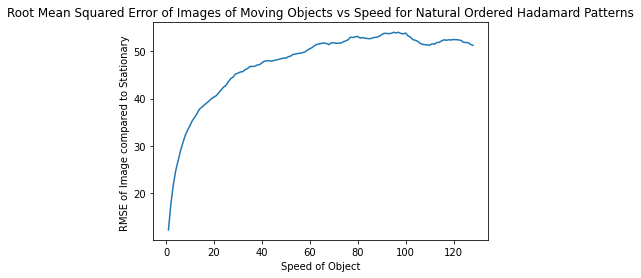

In [7]:
plt.plot(speed,errs_nat)
plt.rcParams['figure.figsize'] = [18,10]
plt.xlabel('Speed of Object')
plt.ylabel('RMSE of Image compared to Stationary ')
plt.title('Root Mean Squared Error of Images of Moving Objects vs Speed for Natural Ordered Hadamard Patterns')
plt.savefig('RMSnat.png')
plt.show()

### RMS for Frequency Ordered Hadamard

Doing the same thing for frequency ordered patterns:

- First creating an array of frequency ordered patterns (sorted_freqs)

In [8]:
sz = 64
patterns = []           # creating empty arrays to bring the patterns and freqs out the loop
freqs = []
for i in range(0,imsize):
    pattern = np.reshape(H[:,i],(sz,sz))
    freq = (np.sum(np.abs(np.diff(pattern,axis=0))) + np.sum(np.abs(np.diff(pattern,axis=1))))/8
    patterns.append(pattern)
    freqs.append(freq)
patterns = np.array(patterns)    # changing the lists to numpy arrays
freqs = np.array(freqs)
inds = freqs.argsort()           # sorting pattern matrices by the frequency number
sorted_h = patterns[inds]
sorted_freqs = sorted(freqs) 


- length = 0 first:

In [9]:
def sorted_spi(imagefile,length):
    raw_img = cv2.imread(imagefile)
    gray_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
    gray_img = cv2.resize(gray_img,(sz*3,sz))
    objs = np.array(gray_img)
    m = np.zeros((imsize,1))
    image = np.zeros((sz,sz))
    
    for i,j in zip(sorted_h,(range(0,imsize))):
        a = round(j*(length/imsize))
        obj = objs[:,a:a+sz]
        m[j] = np.sum(i*obj)
        image = image + m[j]*i
    return image

img_freq0 = sorted_spi(rc64,0)

In [10]:
allimgs_freq = []
for x in speed:
    img_freq = sorted_spi(rc64,x)
    allimgs_freq.append(img_freq)

- Dividing by number of measurements:

In [11]:
allimgs_freq = [i/imsize for i in allimgs_freq]
img_freq0 = img_freq0/imsize

- Finding RMS between each image in allimgs_freq and the still image img_freq0

In [12]:
errs_freq = []
for i in allimgs_freq:
    rms = rmse(img_freq0,i)
    errs_freq.append(rms)

- Plotting:


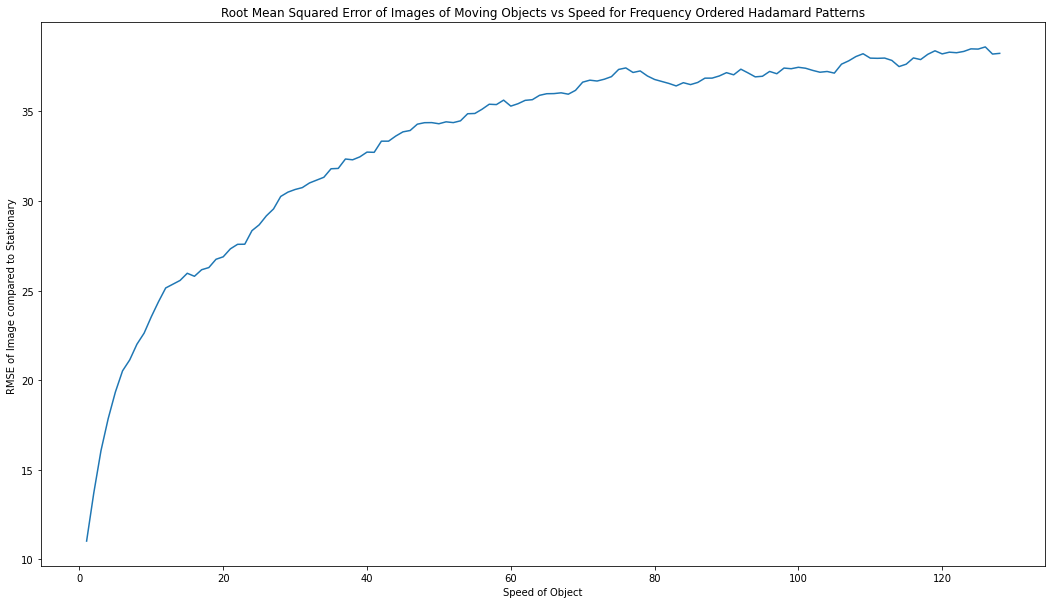

In [13]:
plt.plot(speed,errs_freq)
#plt.plot(speed,errs_nat)
plt.rcParams['figure.figsize'] = [18,10]
plt.xlabel('Speed of Object')
plt.ylabel('RMSE of Image compared to Stationary ')
plt.title('Root Mean Squared Error of Images of Moving Objects vs Speed for Frequency Ordered Hadamard Patterns')
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)     # fontsize of the x and y labels
plt.savefig('RMSfreq.png')
plt.show()

# SSIM Measurements

In [16]:
def Covariance(x, y):
    xbar, ybar = x.mean(), y.mean()
    return np.sum((x - xbar)*(y - ybar))/(len(x) - 1)

def ssim(image1,image2):
    im1_av = np.mean(image1)
    im2_av = np.mean(image2)
    im1_std = np.std(image1)
    im2_std = np.std(image2)
    im12_covar = Covariance(image1,image2)
    L = (2**2) - 1    #<--------------------- i dont know how many bits per pixel to put the power as 
    #c1 = (0.01*L)**2
    #c2 = (0.03*L)**2
    c1 = 0
    c2 = 0

    num = ((2*im1_av*im2_av)+c1)*((2*im12_covar)+c2)
    dem = ((im1_av**2)+(im2_av**2)+c1)*((im1_std**2)+(im2_std**2)+c2)
    
    return num/dem

In [15]:
ssim_nat = []
for i in allimgs_nat:
    ssimvals = ssim(stillcar,i)
    ssim_nat.append(ssimvals)

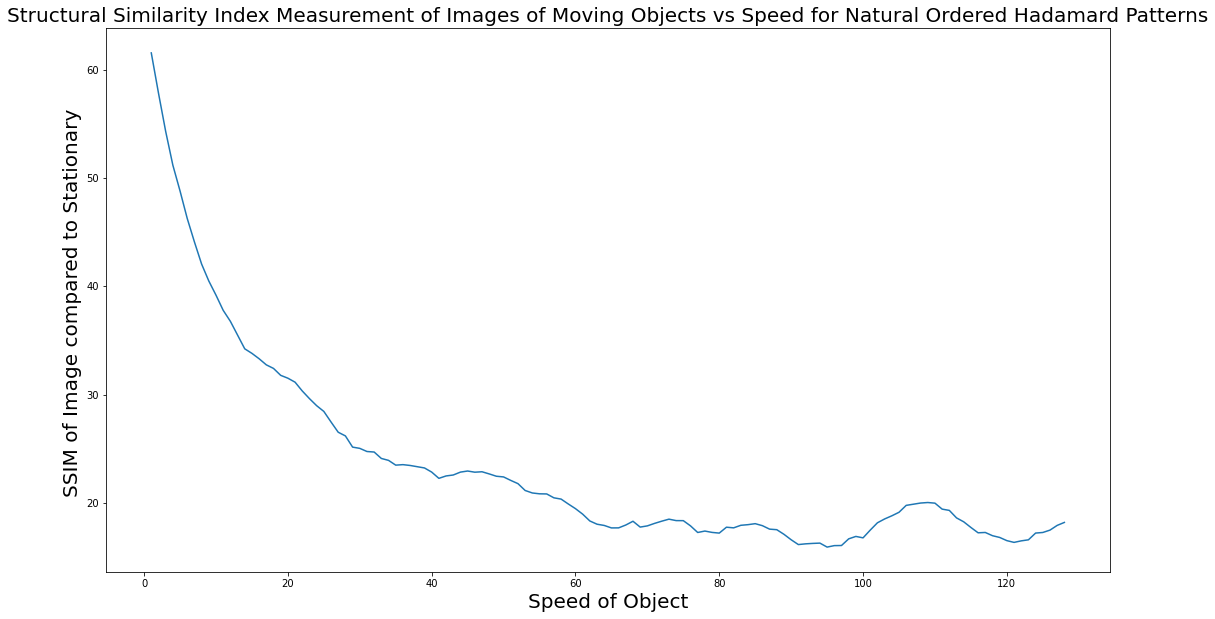

In [19]:
plt.plot(speed,ssim_nat)
plt.rcParams['figure.figsize'] = [18,10]
plt.xlabel('Speed of Object')
plt.ylabel('SSIM of Image compared to Stationary ')
plt.title('Structural Similarity Index Measurement of Images of Moving Objects vs Speed for Natural Ordered Hadamard Patterns')
plt.savefig('RMSnat.png')
plt.show()

In [17]:
ssim_srtd = []
for i in allimgs_freq:
    ssimvals = ssim(img_freq0,i)
    ssim_srtd.append(ssimvals)

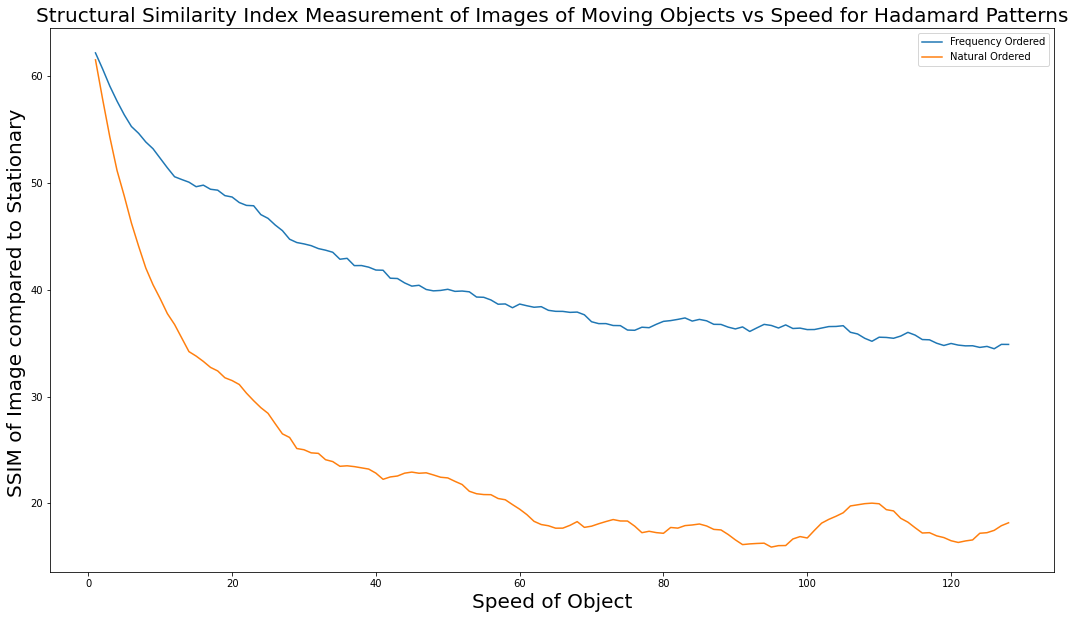

In [25]:
plt.plot(speed,ssim_srtd, label='Frequency Ordered')
plt.plot(speed,ssim_nat, label = 'Natural Ordered')
plt.legend()
plt.rcParams['figure.figsize'] = [18,10]
plt.xlabel('Speed of Object')
plt.ylabel('SSIM of Image compared to Stationary ')
plt.title('Structural Similarity Index Measurement of Images of Moving Objects vs Speed for Hadamard Patterns')
plt.savefig('SSIM.png')
plt.show()